In [1]:
import math
import scipy
import random
import gym
import numpy as np
from control import *
import matplotlib.pyplot as plt
import tensorflow as tensor
import keras.backend as K
from collections import deque
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda, concatenate
from keras.optimizers import Adam
from keras import regularizers
from  control.matlab import *

from ReplayBuffer import ReplayBuffer
from DDPG_Actor_Network import ActorNetwork
from DDPG_Critic_Network import CriticNetwork
from OU import OU
import timeit


OU = OU()


# class DDPG(St, St_next):
#     def __init__(self):
#         self.sess = K.get_session()
#         # update rate for target model
#         self.TAU = 0.01
#         # experience replay 
#         self.memory_buffer = deque(maxlen=50000)
#         # discount rate for q value
#         self.gamma = 0.95
#         # epislon of action selection
#         self.epsilon = 1.0
#         # discount rate for epislon
#         self.epsilon_decay = 0.995
#         # min epislon of e-greedy
#         self.epsilon_min = 0.01
#         # actor learning rate
#         self.actor_lr = 0.0001
#         # critic learning rate
#         self.critic_lr = 0.0001
        
#         # DDPG model
#         self.actor = self._build_actor()
#         self.critic = self._build_critic()

#         # DDPG target model
#         self.target_actor = self._build_actor()
#         self.target_actor.set_weights(self.actor.get_weights())
#         self.target_critic = self._build_critic()
#         self.target_critic.set_weights(self.critic.get_weights())

#         # Gradient function
#         self.get_critic_grad = self.critic_gradient()
#         self.actor_optimizer()

#         def _build_actor(self):
#             inputs = Input(shape=(6,), name='state_input')
#             x = Dense(200, activation='relu6', kernel_regularizers=regularizers.l2(0.01))(inputs)
#             x = Dense(200, activation='relu6', kernel_regularizers=regularizers.l2(0.01))(x)
#             output = Dense(10, activation='relu', kernel_regularizers=regularizers.l2(0.01))(x)

#             model = Model(inputs=inputs, outputs=output)
#             model.compile(loss='mse', optimizer=Adam(lr=self.actor_lr))
#             return model
        
#         def _build_critic(self):
#             inputs = Input(shape=(6,), name='state_input')
#             x = Dense(200, activation='relu6', kernel_regularizers=regularizers.l2(0.01))(inputs)
#             x = Dense(200, activation='relu6', kernel_regularizers=regularizers.l2(0.01))(x)
#             output = Dense(10, activation='relu', kernel_regularizers=regularizers.l2(0.01))(x)

#             model = Model(inputs=inputs, outputs=output)
#             model.compile(loss='mse', optimizer=Adam(lr=self.critic_lr))
#             return model

Tracking_array = []

class environment():
    def reset(self):
        self.kp = 29
        self.ki = 1
        self.kd = 0.001
        self.curIter = 0
        reset_state = [0,0, 0,0,0,0]
#         reset_error = random.uniform(2,10)
        self.error = []
    
        return reset_state


    def env(self, action,curIter):
        self.kp = action[0]
        self.ki = action[1]
        self.kd = action[2]
        # current iteration: 0~100(default setting by scipy.signal.step())
        self.curIter = curIter
        # variable: Jl & Kt 
        # it varies according to different systems (1~3)
        if curIter in range(1000):
            sys_sel = 1
        elif curIter in range(2000,4000):
            sys_sel = 2
        elif curIter in range(4000,6000):
            sys_sel = 1
        elif curIter in range(6000,8000):
            sys_sel = 3
        elif curIter in range(8000,10000):
            sys_sel = 1
        elif curIter in range(10000, 12000):
            sys_sel = 2
        elif curIter in range(12000, 14000):
            sys_sel = 3
        elif curIter in range(14000, 16000):
            sys_sel = 1
        elif curIter in range(16000, 18000):
            sys_sel = 2
        elif curIter in range(18000, 20000):
            sys_sel  = 3
            
        if sys_sel == 1:
            Jl = 2.5*1e-3
            Kt = 1
        elif sys_sel == 2:
            Jl = 6.3*1e-3
            Kt = 1
        elif sys_sel == 3:
            Jl = 2.5*1e-3
            Kt = 3
        # constant
        Jm = 6.329*1e-4
        Tsigma = 1.1*1e-5
        Tsigman = 1.25*1e-4
        B = 3.0*1e-4
        Ksf = (60*1)/(2500*5*1e-3)
        amplitude = 2000
        # sample period: 100us
        T_period = []
        T_ini = 0
#         for _ in range(500000):
#             T_period.append(T_ini)
#             T_ini += 100*1e-6
            
        '''
        speed loop
        Yspeed(s)/W(s) = B1*kd*s^2 + B1*kp*s + B1*ki / A1*s^3 + (B1*kd+A2)*s^2 + (A3+B1*kp)*s + B1*ki
        '''
        A1 = (Jm + Jl) * Tsigman
        A2 = B * Tsigman + (Jm + Jl)
        A3 = B
        B1 = Kt * Ksf
        # speed loop feedback lti system 
#         speed_fb_lti = scipy.signal.lti([B1*self.kd, B1*self.kp, B1*self.ki], [A1, A2+B1*kd, A3+B1*self.kp, B1*self.ki])
        # Angular velocity: Xt
#         t1, Xt = scipy.signal.step(speed_fb_lti, T=T_period)
        # Amplitute: 2000
#         Xt = amplitude * Xt
        '''
        step response
        Y(s)/e(t) = 1
        '''
        feedback_sys = tf([B1*self.kd, B1*self.kp, B1*self.ki], [A1, A2+B1*self.kd, A3+B1*self.kp, B1*self.ki])
            
        Xt, t = step(feedback_sys)
        ## optimal values
        kp_optimal = 8.27e-5 
        ki_optimal = 1.5936e-5 
        kd_optimal  = .00000001
        
        feedback_sys_optimal = tf([B1*kd_optimal, B1*kp_optimal, B1*ki_optimal], [A1, A2+B1*kd_optimal, A3+B1*kp_optimal, B1*ki_optimal])
            
        optimal, t = step(feedback_sys_optimal)
        plt.plot(t,optimal)
        plt.title("optimal signal")
        plt.ylabel("Amplitude")
        plt.xlabel("time")

        ##########################
        # step response feedback lti system
        step_fb_lti = scipy.signal.lti(1, 1)
        # Input signal: Ht
#         t2, Ht = scipy.signal.step(step_fb_lti, T=T_period)
        # Amplitute: 2000
        ## 1000 iterations
        Ht = optimal*1000
        print("Ht", len(Ht))
        
        
        # Tracking error of the output angle of the servo system
        Et = optimal - Xt
        # current time spot of iteration
#         max_len = len(Xt)
        max_len = 100000
        # Integral of absolute error: IAE
        # iae = 0
        # if self.curIter == 0:
        #     iae = 0
        # else:
        #     iae = abs(absolute_Et[self.curIter] - absolute_Et[self.curIter - 1]) * 1
        if self.curIter == 0:
            Xt_last = Xt[0]
            Et_last = Et[0]
            Xt_cur = Xt[self.curIter]
            Et_cur = Et[self.curIter]
            Xt_next = Xt[self.curIter + 1]
            Ht_next = Ht[self.curIter + 1]
            Et_next = Et[self.curIter + 1]
            Ht_a2t = Ht[self.curIter + 2]
            Ht_a3t = Ht[self.curIter + 3]
        elif self.curIter > max_len - 4:
            Xt_last = Xt[self.curIter - 1]
            Et_last = Et[self.curIter - 1]
            Xt_cur = Xt[self.curIter]
            Et_cur = Et[self.curIter]
            Xt_next = Xt[max_len - 1]
            Ht_next = Ht[max_len -1]
            Et_next = Et[max_len -1]
            Ht_a2t = Ht[max_len -1]
            Ht_a3t = Ht[max_len -1]
        else:
#             Xt_last = Xt[self.curIter - 1]
#             Et_last = Et[self.curIter - 1]
            Xt_cur = Xt[self.curIter]
            Et_cur = Et[self.curIter]
            Xt_next = Xt[self.curIter + 1]
            Ht_next = Ht[self.curIter + 1]
            Et_next = Et[self.curIter + 1]
            Ht_a2t = Ht[self.curIter + 2]
            Ht_a3t = Ht[self.curIter + 3]
#         St = [Xt_last, Et_last, Xt_cur, Et_cur, Ht_next, Ht_a2t]
        St_next = [Xt_cur, Et_cur, Xt_next, Et_next, Ht_a2t, Ht_a3t]
        Tracking_array.append(Xt_cur)

        absolute_It = 0

#         reward  = math.exp(pow(((0.9 *(Et_cur) / amplitude + 0.1 * abs(absolute_It) / amplitude)), 2)/ (-2) * pow(10, 2))
        reward  = 1/(abs(math.exp(abs(Et_cur))))
        done  = False
        return St_next,reward,done

#         plt.plot(t1, Xt)
        # plt.xlabel('Time(s)')
        # plt.ylabel('Angular velocity')
        # plt.savefig('Angular velocity.jpg')
        # plt.show()
        # plt.plot(t2, Ht)
        # plt.xlabel('Time(s)')
        # plt.ylabel('Tracking signal')
        # plt.savefig('Tracking signal.jpg')
#         plt.show()
#         return Xt
        # return St, S(t+1), reward, t1: for plot usage
        
 























PID = environment()

def play():
    
    BUFFER_SIZE = 100000
    BATCH_SIZE = 125
    GAMMA = 0.90
    TAU = 0.001     #Target Network HyperParameters
    LRA = 0.0005    #Learning rate for Actor
    LRC = 0.005 
    action_size = 3
    action_dim = 3
    state_dim  = 6
    np.random.seed(1337)
    
    vision = False
    EXPLORE = 100000.
    episode_count = 10000
    max_steps = 100000
    reward = 0
    done = False
    step = 0
    epsilon = 1
    indicator = 0
    train_indicator = 1
    
    config = tensor.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tensor.Session(config=config)
    from keras import backend as K
    K.set_session(sess)
    
    actor = ActorNetwork(sess, state_dim, action_dim, BATCH_SIZE, TAU, LRA)
    critic = CriticNetwork(sess, state_dim, action_dim, BATCH_SIZE, TAU, LRC)
    buff = ReplayBuffer(BUFFER_SIZE)    #Create replay buffer
    
    for i in range(episode_count):
        print("Episode : " + str(i) + " Replay Buffer " + str(buff.count())) 
#         total_reward = 0.
#         Xt_last = 1444
#         Et_last = 22
#         Xt_cur = 344
#         Et_cur = 534
#         Ht_next = 2000
#         Ht_a2t = 2000
        state = PID.reset()
        print("reset_error", state)

        
        for j in range(max_steps):
            
            loss = 0
            epsilon  -= 1.0/ EXPLORE
            a_t = np.zeros([1, action_size])
            noise_t = np.zeros([1, action_size])
            
            a_t_original = actor.model.predict(np.array([state]))
#             print("a_t_original: ", a_t_original)
            noise_t[0][0] = train_indicator * max(epsilon, 0) * OU.function(a_t_original[0][0], 2 , 0.01, 0.005)
            noise_t[0][1] = train_indicator * max(epsilon, 0) * OU.function(a_t_original[0][1], 2 , 0.01, 0.005)
            noise_t[0][2] = train_indicator * max(epsilon, 0) * OU.function(a_t_original[0][2], 2 , 0.01, 0.005)
            
            a_t[0][0] = a_t_original[0][0] + noise_t[0][0]
            a_t[0][1] = a_t_original[0][1] + noise_t[0][1]
            a_t[0][2] = a_t_original[0][2] + noise_t[0][2]
            
                    
#             print("a_t", a_t[0])
            next_state, reward,done  = PID.env(a_t[0], j)
            print("current_state", next_state[1])
#             print("next_state",next_state[3])
            print("reward", reward)
            buff.add(state, a_t[0], reward, next_state, done)   
            batch = buff.getBatch(BATCH_SIZE)
            states = np.asarray([e[0] for e in batch])
            actions = np.asarray([e[1] for e in batch])
            rewards = np.asarray([e[2] for e in batch])
            next_states = np.asarray([e[3] for e in batch])
            dones = np.asarray([e[4] for e in batch])
            y_t = np.asarray([e[1] for e in batch])
            target_q_values = critic.target_model.predict([next_states, actor.target_model.predict(next_states)])
            for k in range(len(batch)):
                if dones[k]:
                    y_t[k] = rewards[k]
                else:
                    y_t[k] = rewards[k] + GAMMA*target_q_values[k]
                    
        
            if (train_indicator):
                loss += critic.model.train_on_batch([(states),actions], y_t) 
#                 print("loss",loss)
                a_for_grad = actor.model.predict(states)
                if buff.count() <= BATCH_SIZE:
                    K= buff.count()
                else:
                    K = BATCH_SIZE
                states = states.reshape(K,6)
                grads = critic.gradients(states, a_for_grad)
                
                actor.train(states, grads)
                actor.target_train()
                critic.target_train()
                
            
            state = next_state
#             total_reward += reward
#             print("total_reward", reward)
            
            
#             if done:
#                 if j == 999:
#                     iterations.append(j)
#                 break 
            
                
if __name__ == "__main__":
    play()
warnings.filterwarnings("ignore")



Using TensorFlow backend.


In [2]:

for i in range(100):
    
    
    x,done = PID.env(8.27e-5 ,1.5936e-5 ,.00000001,i )


NameError: name 'PID' is not defined

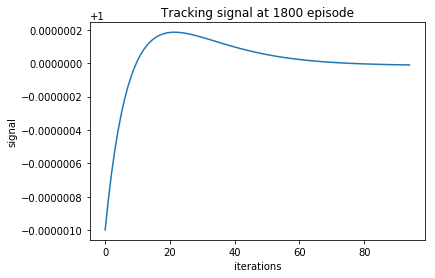

In [16]:

plt.plot(np.arange(95),np.absolute(Tracking_array[180005:180100]))
plt.title("Tracking signal at 1800 episode")
plt.xlabel("iterations")
plt.ylabel("signal")
plt.show()

In [ ]:
classic = np.absolute(classic_error[500:14428])
plt.plot(np.arange(1, 13928), classic)
plt.xlabel("iterations")
plt.ylabel("Error")
plt.title("Performance of traditional tuning")
plt.grid()
plt.show()

In [ ]:
print(classic_error)

In [13]:
Tracking_array

[0.0, 0.07968802648252679, 0.15732822502363478, 0.23247646701793553]

In [ ]:
plt.plot(np.arange(100), x)
plt.show()

In [46]:
values = []
for i in range(0,500000,1000):
    values.append(Tracking_arrar[0][i])
    

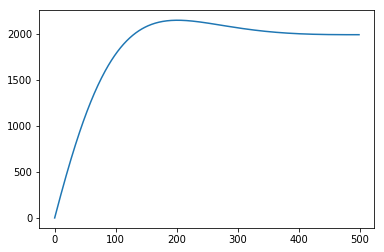

In [47]:
plt.plot(np.arange(500), values)
plt.show()

In [41]:
len(Tracking_array)

100

In [3]:
a = [1,2,4]

b = a*2
b

[1, 2, 4, 1, 2, 4]

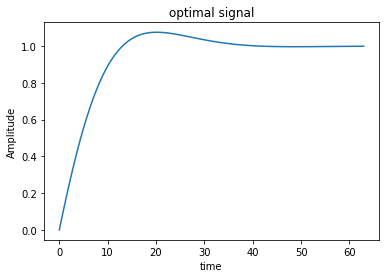

In [4]:
environment = environment()
environment.env(a,1)